# Hypothesis Tests 

In [20]:
from scipy import stats

In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# String INTs Function
def shrink_ints(df):
    mapping = {}
    for col in df.dtypes[df.dtypes == 'int64[pyarrow]'].index:
        max_ = df[col].max()
        min_ = df[col].min()
        if min_ < 0:
            continue
        elif max_ < 255:
            mapping[col] = 'uint8[pyarrow]'
        elif max_ < 65_535:
            mapping[col] = 'uint16[pyarrow]'
        elif max_ < 4294967295:
            mapping[col] = 'uint64[pyarrow]'
        return df.astype(mapping)




# Creating a clean_housing function
def clean_housing_no_na(df):
    return(
    df
    # Using the assign method to update records
    .assign(
        # Update the 
        **df
            # Select the string cols in the df
            .select_dtypes('string')
            # replace all the NA values in the df with Missing
            .replace('', 'Missing')
            # Convert to category
            .astype('category'),
        # Using dictionary unpacking to update the Garage col with clipped col
        **{'Garage Yr Blt': df['Garage Yr Blt'].clip(upper=df['Year Built'].max())}      
    )
    # Convert the numerical variables to the right datatypes to save memory
    .pipe(shrink_ints)
    # Fill missing values integer values with the mean of the respective int cols
    .pipe(lambda df_: df_.assign(**df_.select_dtypes('int').fillna(df_.select_dtypes('int').mean())))
    # Fill missing categorical values with the mode of the respective col
    .pipe(lambda df_: df_.assign(**df_.select_dtypes('category').fillna(df_.select_dtypes('category').mode())))
    )



# Execute the Pipeline
url = 'AmesHousing.csv'

# Load the data
# Engine = Pyarrow makes the back-end quicker with pyarrow and the pyarrow data types
df = pd.read_csv(url, engine='pyarrow', dtype_backend='pyarrow')

# Clean the data and Preview the result
aimes_df = clean_housing_no_na(df)

In [2]:
(
    aimes_df
    # Select the Neighborhood col
    ['Neighborhood']
    # Count
    .value_counts()
)

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: count, dtype: int64

In [4]:
(
    aimes_df
    # Group by Neighbourhood
    .groupby('Neighborhood')
    # Descirbe aggregation
    .describe()
    # Select relevant cols
    .loc[['CollgCr', 'NAmes'], 'SalePrice']
)

,count,mean,std,min,25%,50%,75%,max
Neighborhood,,,,,,,,
CollgCr,267.0,201803.434457,54187.843749,110000.0,160875.0,200000.0,228250.0,475000.0
NAmes,443.0,145097.349887,31882.707229,68000.0,127000.0,140000.0,157500.0,345000.0


In [5]:
(
    aimes_df
    # Group by Neighbourhood
    .groupby('Neighborhood')
    # Descirbe aggregation
    .describe()
    # Select relevant cols
    .loc[['CollgCr', 'NAmes'], 'SalePrice']
    # Transpose
    .T
)

Neighborhood,CollgCr,NAmes
count,267.000000,443.000000
mean,201803.434457,145097.349887
std,54187.843749,31882.707229
min,110000.000000,68000.000000
25%,160875.000000,127000.000000
50%,200000.000000,140000.000000
75%,228250.000000,157500.000000
max,475000.000000,345000.000000


## Visualizing Distributions

- Make histograms of both distributions
- Cumulative Distribution Plot

In [6]:
n_ames = (
            aimes_df
            # Query Neighborhood = NAmes
            .query("Neighborhood == 'NAmes'")
            # Select the Sale Price
            ['SalePrice']
)

n_ames.head()

0     215000
1     105000
2     172000
3     244000
23    149000
Name: SalePrice, dtype: int64[pyarrow]

In [8]:
college_cr = (
            aimes_df
            # Query Neighborhood = NAmes
            .query("Neighborhood == 'CollgCr'")
            # Select the Sale Price
            ['SalePrice']
)

college_cr.head()

249    245350
250    206000
251    198900
252    187000
256    159000
Name: SalePrice, dtype: int64[pyarrow]

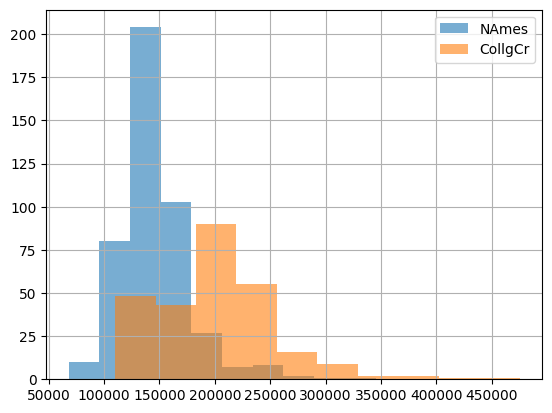

In [10]:
# Plotting the histogram on the same plots
alpha = 0.6

ax = n_ames.hist(label='NAmes', alpha=alpha)

college_cr.hist(ax=ax, label='CollgCr', alpha=alpha)

ax.legend()

<Axes: xlabel='SalePrice'>

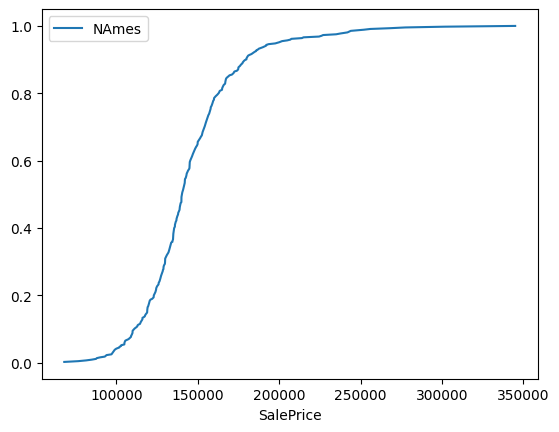

In [11]:
# Cummulative Density Plot

(
    n_ames
    # Convert to DF
    .to_frame()
    # Perform an assignment operation
    .assign(cdf=n_ames.rank(method='average', pct=True))
    # Sort the values b y SalePrice
    .sort_values(by='SalePrice')
    # Lets plot a lineplot
    .plot(x='SalePrice', y='cdf', label='NAmes')
)

0       215000
1       105000
2       172000
3       244000
23      149000
         ...  
2630    155000
2631    134500
2632    120000
2633    105000
2634    124000
Name: SalePrice, Length: 443, dtype: int64[pyarrow]

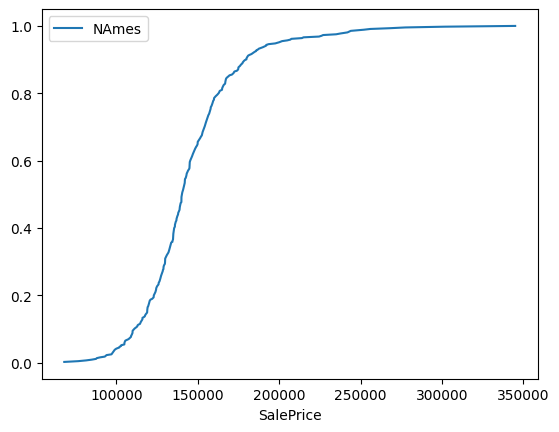

In [17]:
# Cummulative Density Plot

def plot_cdf(ser, ax=None, label=''):
    (
        ser
        # Convert to DF
        .to_frame()
        # Perform an assignment operation
        .assign(cdf=ser.rank(method='average', pct=True))
        # Sort the values b y SalePrice
        .sort_values(by='SalePrice')
        # Lets plot a lineplot
        .plot(x='SalePrice', y='cdf', label=label, ax=ax)
    )
    return ser



plot_cdf(ser=n_ames, label='NAmes')

249     245350
250     206000
251     198900
252     187000
256     159000
         ...  
2811    196500
2812    198000
2813    173900
2814    163990
2815    164990
Name: SalePrice, Length: 267, dtype: int64[pyarrow]

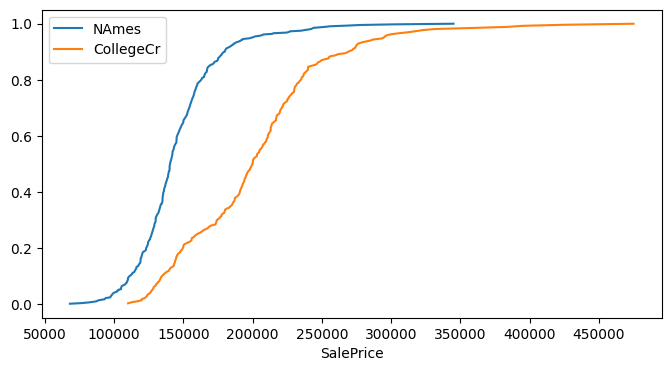

In [18]:


fig, ax_1 = plt.subplots(figsize=(8,4))

plot_cdf(ser=n_ames, label='NAmes', ax=ax_1)

plot_cdf(ser=college_cr, label='CollegeCr', ax=ax_1)

> CDFs do not overlap meaning they do not belong to the same distribution

## Running Statistical Tests
- Use the `scipy.stats` module to run statistical tests 

In [21]:
# Check the library

print(dir(stats))

['ConstantInputWarning', 'Covariance', 'DegenerateDataWarning', 'FitError', 'NearConstantInputWarning', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_axis_nan_policy', '_biasedurn', '_binned_statistic', '_binomtest', '_boost', '_common', '_constants', '_continuous_distns', '_covariance', '_crosstab', '_discrete_distns', '_distn_infrastructure', '_distr_params', '_entropy', '_fit', '_hypotests', '_kde', '_ksstats', '_levy_stable', '_mannwhitneyu', '_morestats', '_mstats_basic', '_mstats_extras', '_multivariate', '_mvn', '_odds_ratio', '_page_trend_test', '_qmc', '_qmc_cy', '_rcont', '_relative_risk', '_resampling', '_rvs_sampling', '_sobol', '_statlib', '_stats', '_stats_mstats_common', '_stats_py', '_stats_pythran', '_tukeylambda_stats', '_variation', '_warnings_errors', 'alexandergovern', 'alpha', 'anderson', 'anderson_ksamp', 'anglit', 'ansari', 'arcsine', 'argus', 'barnard_exact', 'bartlett', 'bayes

In [22]:
stats.ks_2samp??

Signature: stats.ks_2samp(data1, data2, alternative='two-sided', method='auto')
Source:   
@_rename_parameter("mode", "method")
def ks_2samp(data1, data2, alternative='two-sided', method='auto'):
    """
    Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.

    This test compares the underlying continuous distributions F(x) and G(x)
    of two independent samples.  See Notes for a description of the available
    null and alternative hypotheses.

    Parameters
    ----------
    data1, data2 : array_like, 1-Dimensional
        Two arrays of sample observations assumed to be drawn from a continuous
        distribution, sample sizes can be different.
    alternative : {'two-sided', 'less', 'greater'}, optional
        Defines the null and alternative hypotheses. Default is 'two-sided'.
        Please see explanations in the Notes below.
    method : {'auto', 'exact', 'asymp'}, optional
        Defines the method used for calculating the p-value.
        The followin

In [24]:
ks_stat, p_value =  stats.ks_2samp(n_ames, college_cr)


In [ ]:
if p_value > 0.05:
    print('Fail to reject the NH: Same distribution')

else:
    print('Reject the NH: Not from same distribution')

> Since the p-value is less than 0.05, we fail to reject the null hypothesis that the 2 samples are from the same distribution